In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import PolynomialFeatures,StandardScaler,MinMaxScaler,PowerTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV,train_test_split,TimeSeriesSplit
from sklearn import metrics
import re
import random
from statsmodels.tsa.seasonal import seasonal_decompose
from random import randrange
import scipy.stats as stats
import matplotlib.image as mpimg
import pmdarima as pm

In [2]:
# reading data

data = pd.read_csv(r"GlobalLandTemperaturesByCity.csv").dropna()
data.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
5,1744-04-01,5.788,3.624,Århus,Denmark,57.05N,10.33E
6,1744-05-01,10.644,1.283,Århus,Denmark,57.05N,10.33E
7,1744-06-01,14.051,1.347,Århus,Denmark,57.05N,10.33E
8,1744-07-01,16.082,1.396,Århus,Denmark,57.05N,10.33E


In [3]:
# creating "year" column for easier yearly mean calculation
# for date in data.dt:
data["year"] = [int(date[0:4]) for date in data.dt]
data.year

0          1743
5          1744
6          1744
7          1744
8          1744
           ... 
8599206    2013
8599207    2013
8599208    2013
8599209    2013
8599210    2013
Name: year, Length: 8235082, dtype: int64

<ipython-input-31-8361ad0f3ee5>:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_major_locator(plt.MaxNLocator(20))


Text(0.5, 1.0, 'Change of yearly mean temperatures in Aarhus')

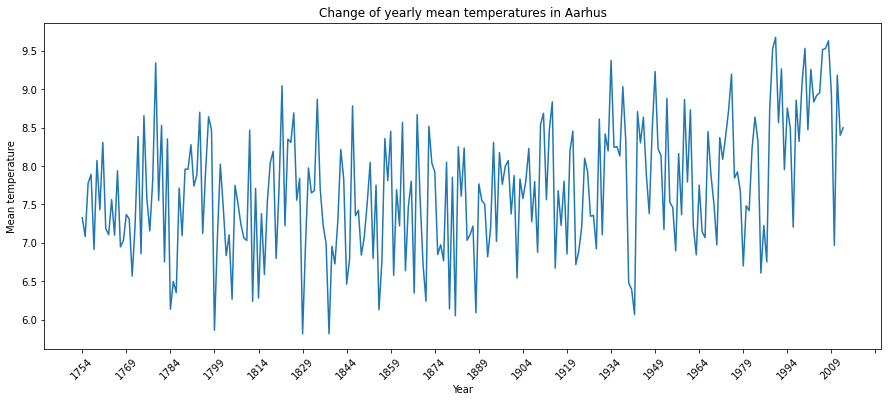

In [31]:
# Plotting yearly temperatures for Aarhus - first look

aarhus = data[data.City == "Århus"]
aarhus = aarhus[50:]
yearly = aarhus.groupby("year").mean()

plt.figure(figsize=(15,6))
plt.plot(yearly.index, yearly.AverageTemperature)
plt.xlabel("Year")
plt.ylabel("Mean temperature")
# limiting number of xticks 
plt.axes().xaxis.set_major_locator(plt.MaxNLocator(20))
plt.xticks(rotation=45)
plt.title("Change of yearly mean temperatures in Aarhus")

### Is the temperature in 2000s significantly higher than in 1900s?

In [213]:

# grouping data by city
data_grouped = data.groupby(["City","year"]).mean().reset_index()


In [215]:
hotter = {}
unchanged = {}
for city in list(data_grouped.City.unique()):
    # getting data, splitting into two sets
    city_data = data_grouped[data_grouped.City == city]
    city_1900 = city_data[(city_data.year >= 1900) & (city_data.year <= 1990)]
    city_2000 = city_data[(city_data.year >= 2000) & (city_data.year <= 2013)]
    # checking equality of variance:
    levene_result = stats.levene(city_1900.AverageTemperature,city_2000.AverageTemperature)[1]
    # setting parameters values for equal and unequal variances
    if levene_result < 0.05:
        equal_variance = False
    else:
        equal_variance = True
        
    t_result = stats.ttest_ind(city_1900.AverageTemperature,city_2000.AverageTemperature, equal_var = equal_variance)[1]
    if t_result < 0.05:
        hotter[city] = city_2000.AverageTemperature.mean() - city_1900.AverageTemperature.mean()
    else:
        unchanged[city] = city_2000.AverageTemperature.mean() - city_1900.AverageTemperature.mean()


In [225]:
# changing hotter into series for easier calculations
hotter_series = pd.Series(hotter)

In [228]:
# printinh out results
print(f"Out of {len(data_grouped.City.unique())} cities in dataset, in {len(hotter)} of them mean temperature between years 2000 and 2013 is significantly higher than between 1900 and 1990.")
print(f"This makes {len(data_grouped.City.unique())/len(hotter)*100} percent of the dataset")
print(f"City with highest mean temperature change is {hotter_series.idxmax()} in {data[data.City==hotter_series.idxmax()].Country.iloc[0]} with change of {hotter_series.max()}")
print(f"City with lowest mean temperature change is {hotter_series.idxmin()} in {data[data.City==hotter_series.idxmin()].Country.iloc[0]} with change of {hotter_series.min()}")

Out of 3448 cities in dataset, in 3448 of them mean temperature between years 2000 and 2013 is significantly higher than between 1900 and 1990.
This makes 100.0 percent of the dataset
City with highest mean temperature change is Engels in Russia with change of 1.901936813186813
City with lowest mean temperature change is Juliaca in Peru with change of 0.2560533424908433


## Choosing cities for more detailed analisys and plotting data

In [4]:
# choosing countries for analisys -- aiming for variety

countries = ["Norway","Ireland","Italy","Mexico","Peru","Ethiopia","Nigeria","South Korea","India","New Zealand","Jordan","Iran"]

In [5]:
data_chosen = data[data.Country.isin(countries)]

In [6]:
# choosing cities for analisys:
cities = []
for country in countries:
    data_country = data_chosen[data_chosen.Country == country]
    city = random.choice(list(data_country.City.unique()))
    cities.append(city)

In [217]:
list(cities)

['Bangalore',
 'Christchurch',
 'Cork',
 'Gonbad E Qabus',
 'Huancayo',
 'Ilesha',
 'Irbid',
 'Jimma',
 'Messina',
 'Seoul',
 'Trondheim',
 'Tuxtla Gutiérrez']

In [114]:
# creating dataframe with data only for chosen cities
data_cities = data_chosen[data_chosen.City.isin(cities)]
# replacing longitude and latitude with numerical values
for i in range(len(data_cities.Longitude)):
    if data_cities.Longitude.iloc[i][-1] == "E":
        try:
            data_cities.Longitude.iloc[i] = float(data_cities.Longitude.iloc[i][0:5])
        except:
            data_cities.Longitude.iloc[i] = float(data_cities.Longitude.iloc[i][0:4])
    elif data_cities.Longitude.iloc[i][-1] == "W":
        try:
            data_cities.Longitude.iloc[i] = -float(data_cities.Longitude.iloc[i][0:5])
        except:
            data_cities.Longitude.iloc[i] = -float(data_cities.Longitude.iloc[i][0:4])
for i in range(len(data_cities.Latitude)):
    if data_cities.Latitude.iloc[i][-1] == "N":
        try:
            data_cities.Latitude.iloc[i] = float(data_cities.Latitude.iloc[i][0:5])
        except:
            data_cities.Latitude.iloc[i] = float(data_cities.Latitude.iloc[i][0:4])
    elif data_cities.Latitude.iloc[i][-1] == "S":
        try:
            data_cities.Latitude.iloc[i] = -float(data_cities.Latitude.iloc[i][0:5])
        except:
            data_cities.Latitude.iloc[i] = -float(data_cities.Latitude.iloc[i][0:4])
    

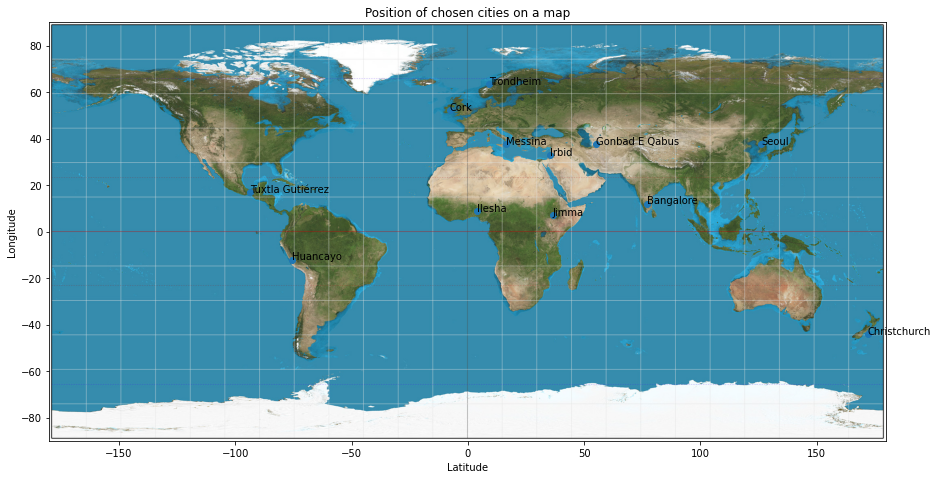

In [122]:
# Showing geographical locations of chosen cities on a world map
# updating cities variable to have same order
cities = data_cities.City.unique()
# loading image - map
world_map = mpimg.imread("world.jpg")
# creating list of longitudes
longitudes = [x for x in list(data_cities.Longitude.unique())]
# multiple cities on one latitude, different method
latitudes = []
for city in cities:
    latitudes.append(data_cities[data_cities.City == city].Latitude.iloc[0])

# plotting
plt.figure(figsize=(15,10))
plt.scatter(longitudes,latitudes)
# adding labels for points on map
for i, txt in enumerate(cities):
    plt.annotate(txt, (longitudes[i], latitudes[i]))
# showing map image
plt.imshow(world_map, extent=[-180.00, 180.00, -90, 90.00])
plt.ylabel("Longitude")
plt.xlabel("Latitude")
plt.title("Position of chosen cities on a map")
plt.show()


In [9]:
# creating dictionary with dataframes for each city for easier access
cities_dict = {}

for city in cities:
    data_city = data_cities[data_cities.City == city]
    
    # dropping data from years where there are gaps in data (less than 12 values)
    by_years = data_city.groupby("year").size()
    years_to_drop = []
    for year in list(by_years.index):
        if by_years[year] != 12:
            years_to_drop.append(year)
    data_city.drop(data_city[data_city.year.isin(years_to_drop)].index,inplace=True)        

    
    
    # adding resulting dataframe to a dictionary
    cities_dict[city] = data_city


C:\Users\szklarnia\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


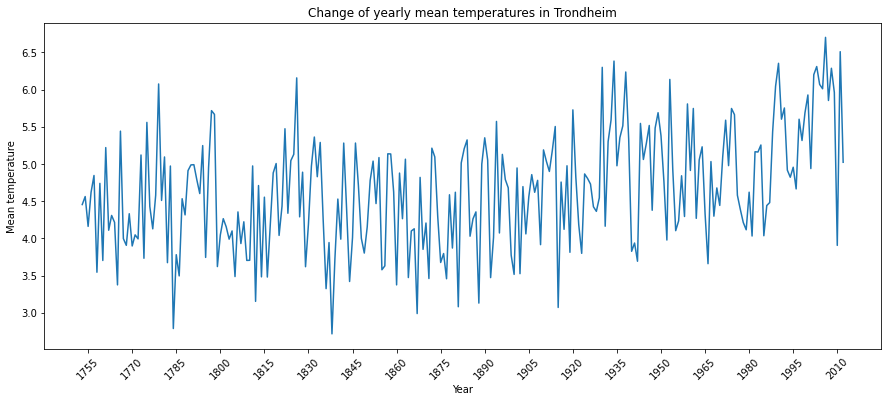

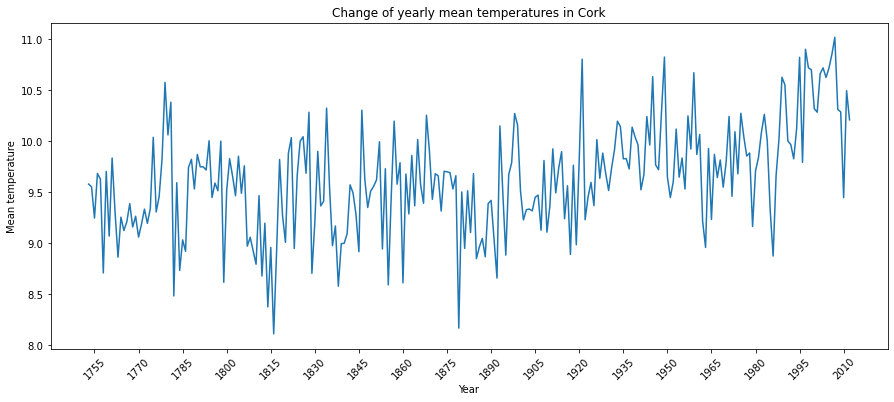

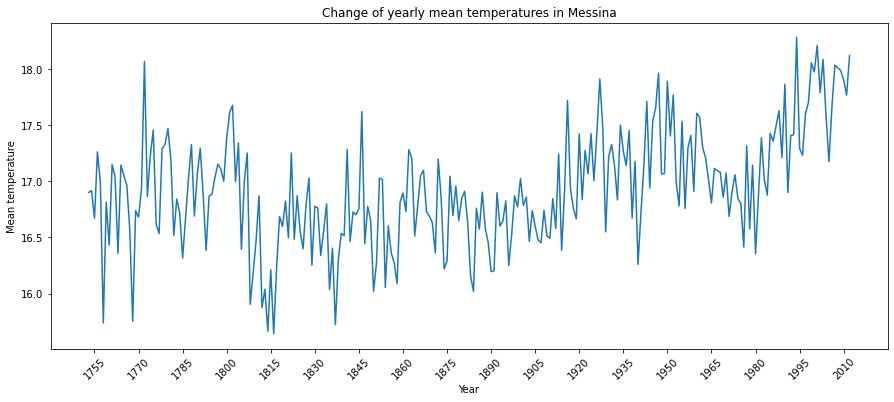

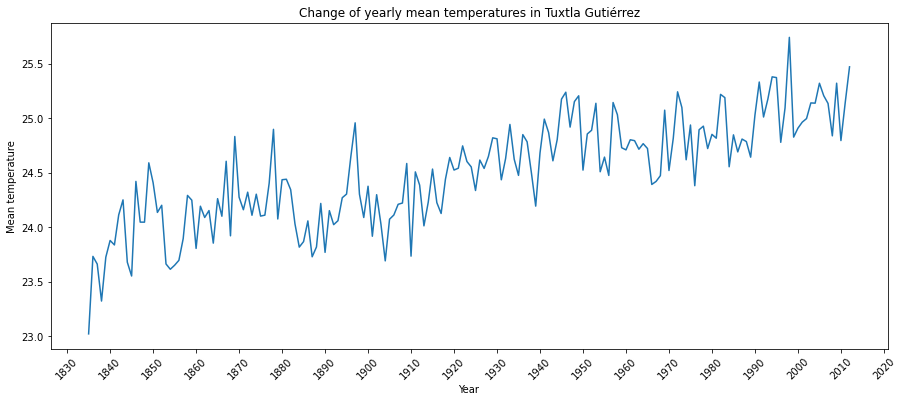

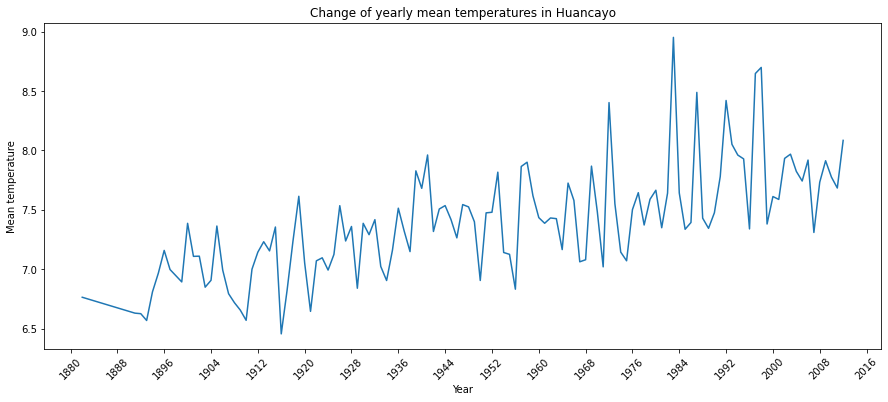

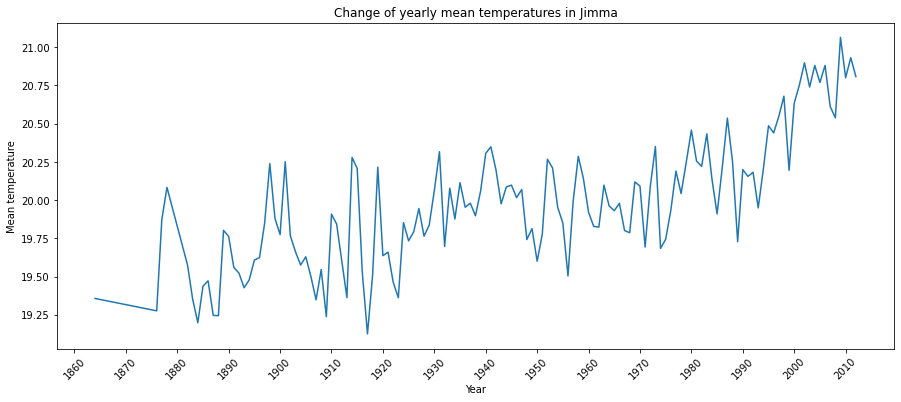

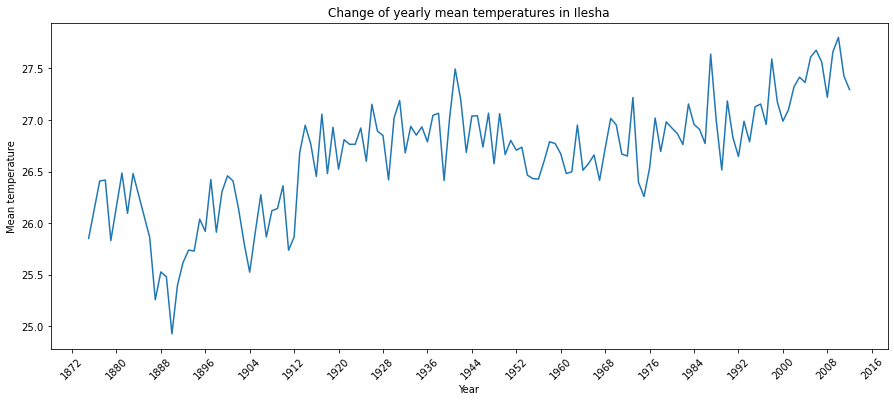

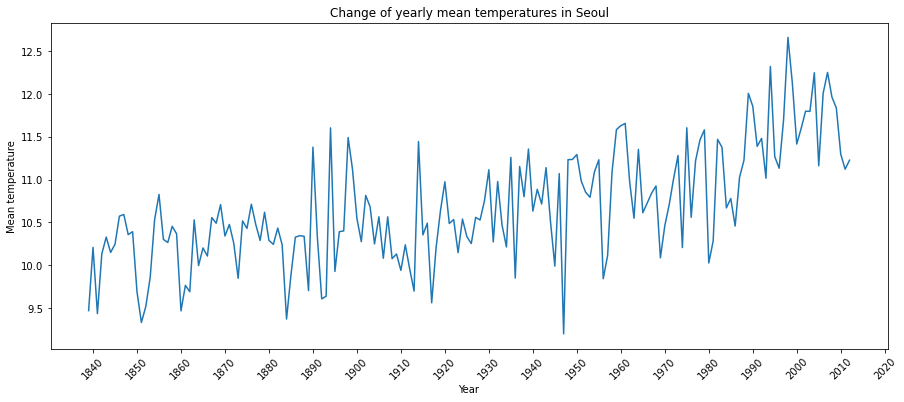

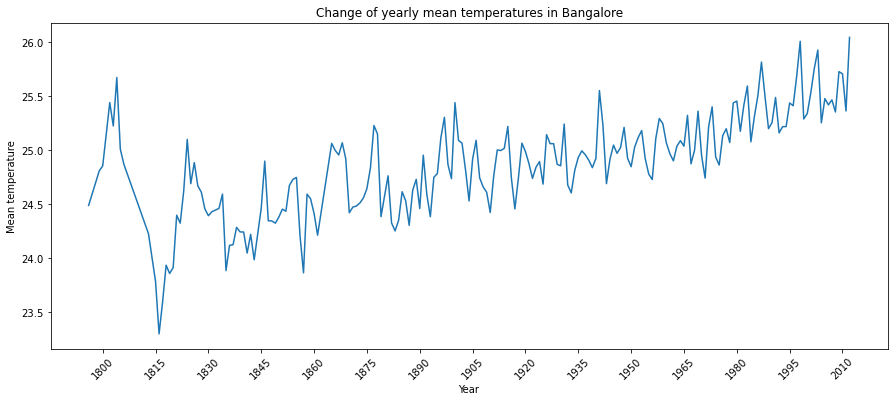

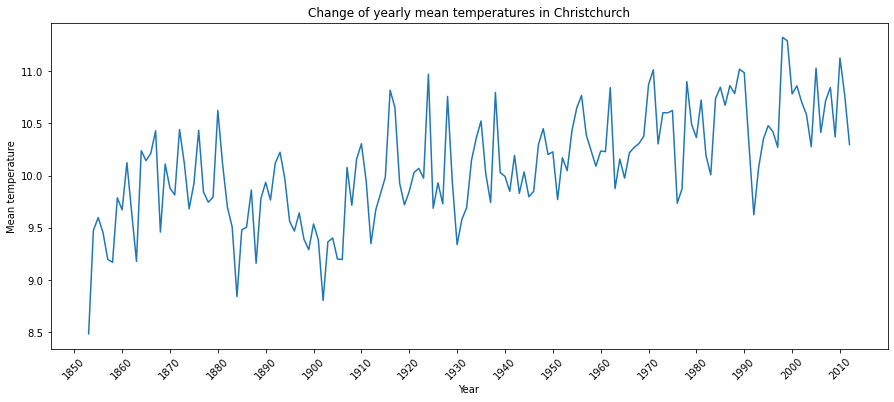

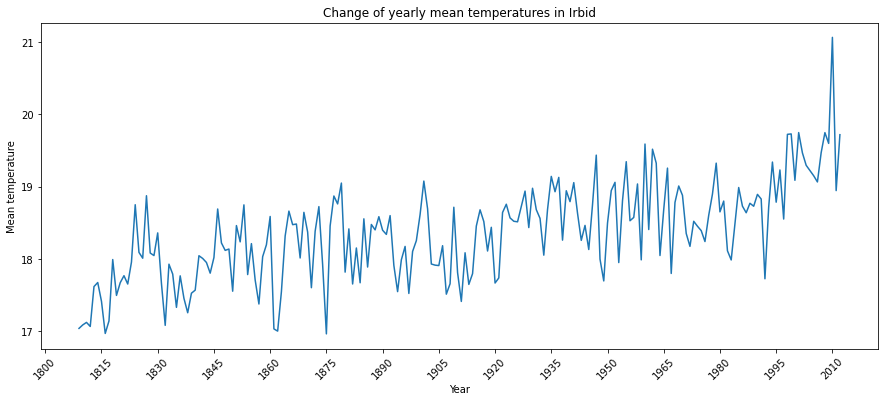

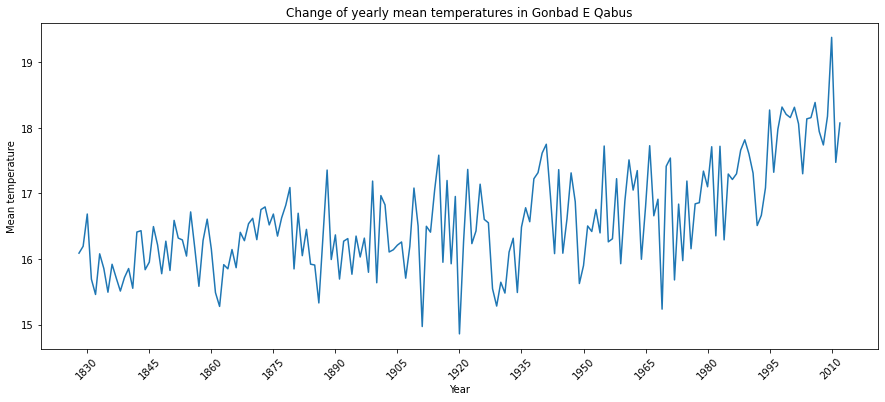

In [218]:
# plotting yearly mean temperatures for chosen cities

# iterating over cities
for key in cities_dict.keys():
    # creating yearly means for each place
    data_city = cities_dict[key]
    yearly = data_city.groupby("year").mean()
    
    # plotting
    plt.figure(figsize=(15,6))
    plt.plot(yearly.index, yearly.AverageTemperature)
    plt.xlabel("Year")
    plt.ylabel("Mean temperature")
    # limiting number of ticks showing on x axis
    plt.axes().xaxis.set_major_locator(plt.MaxNLocator(20))
    plt.xticks(rotation=45)
    plt.title(f"Change of yearly mean temperatures in {key}")

plt.show()

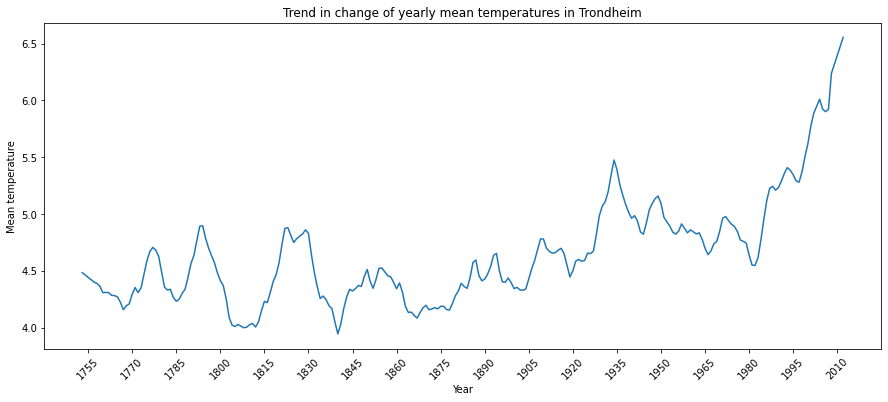

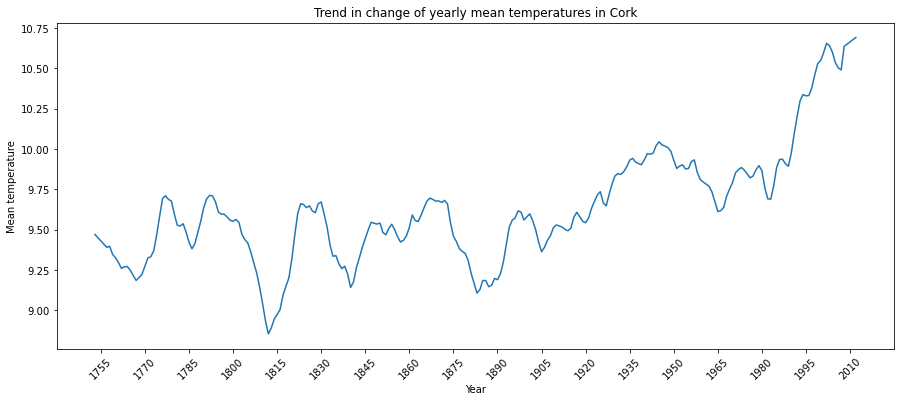

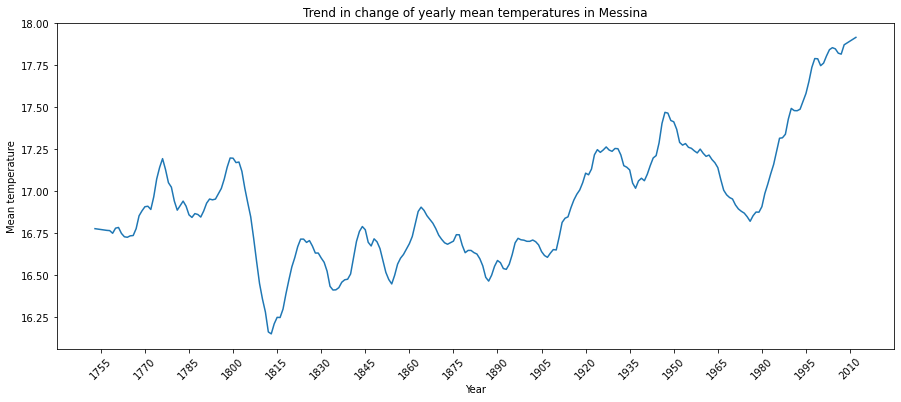

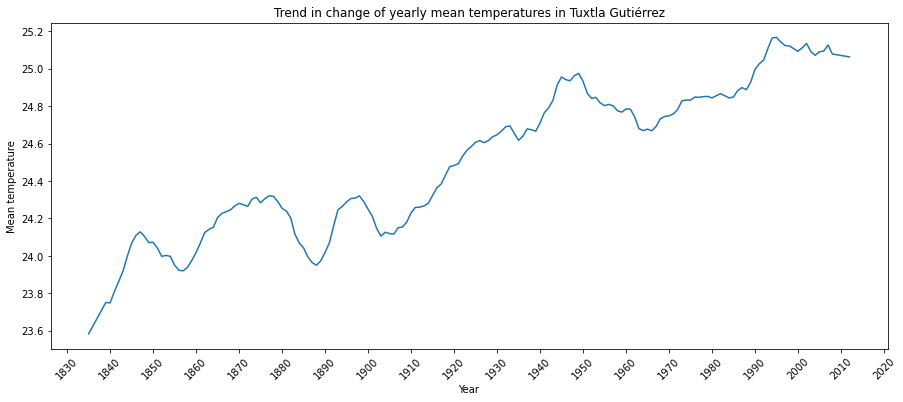

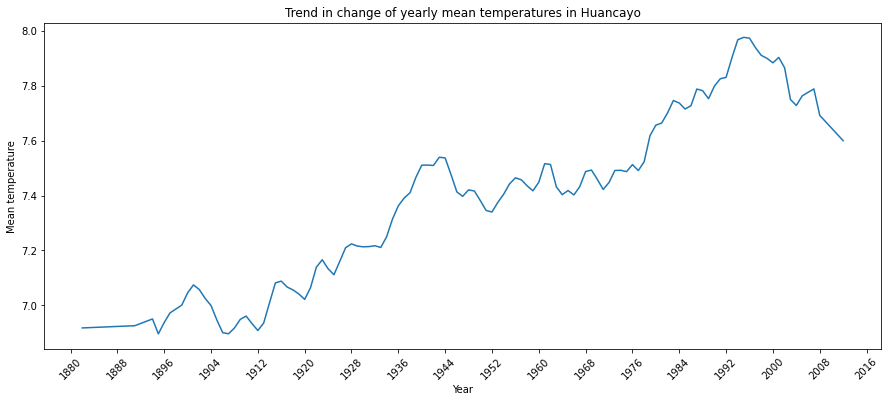

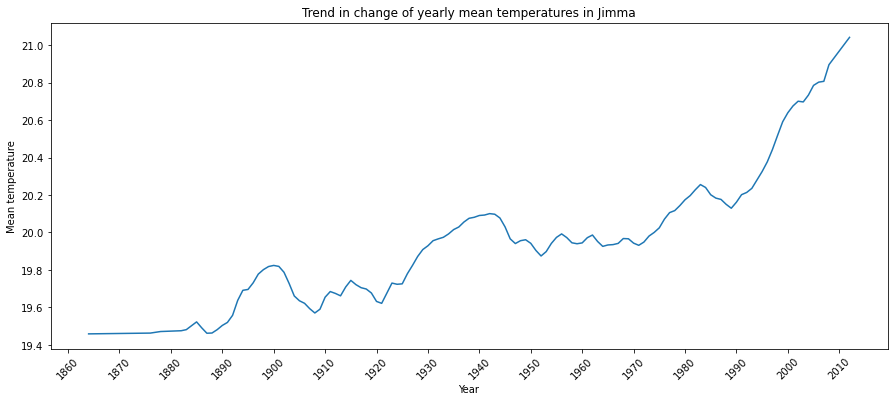

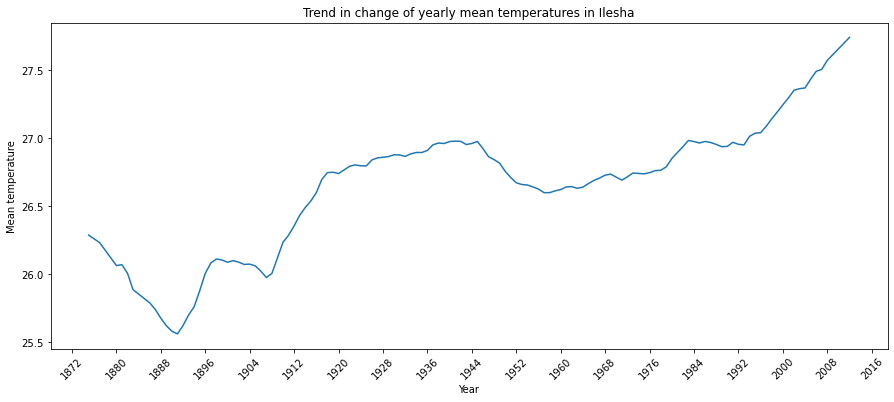

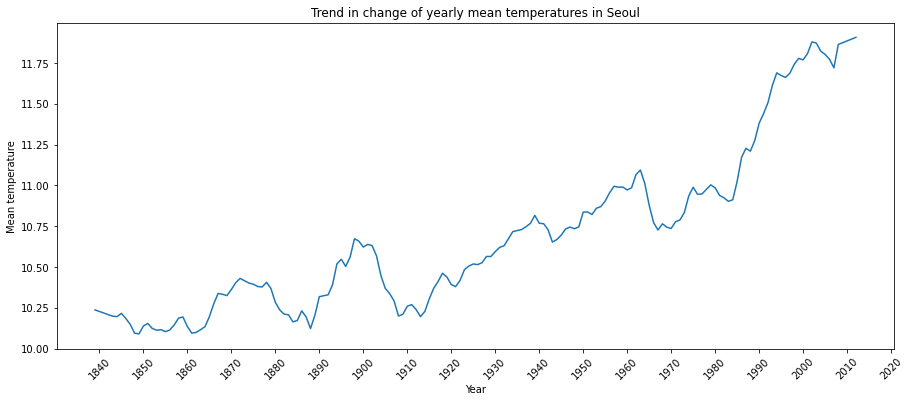

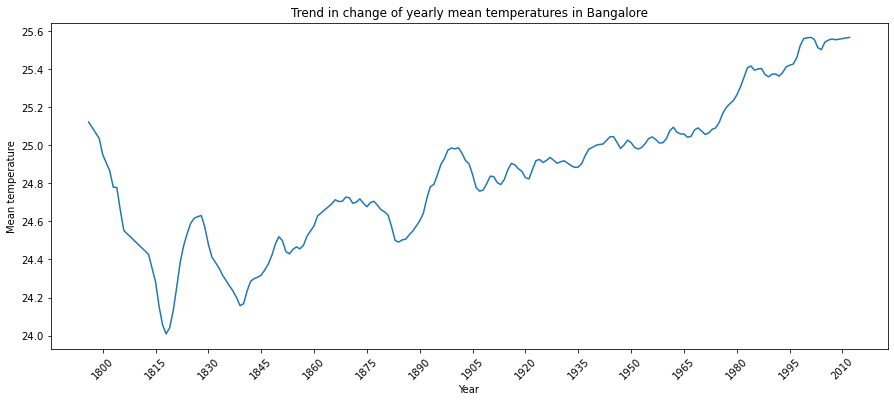

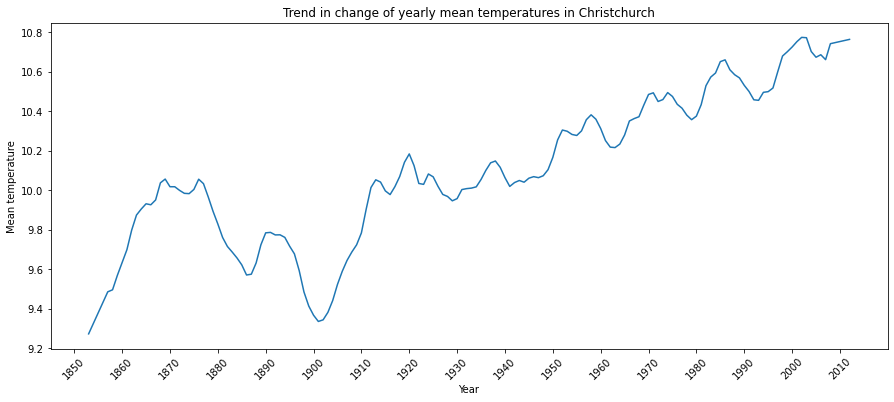

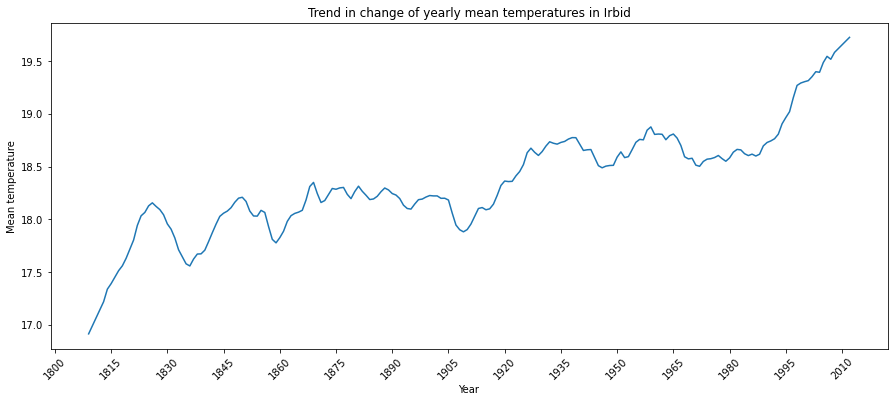

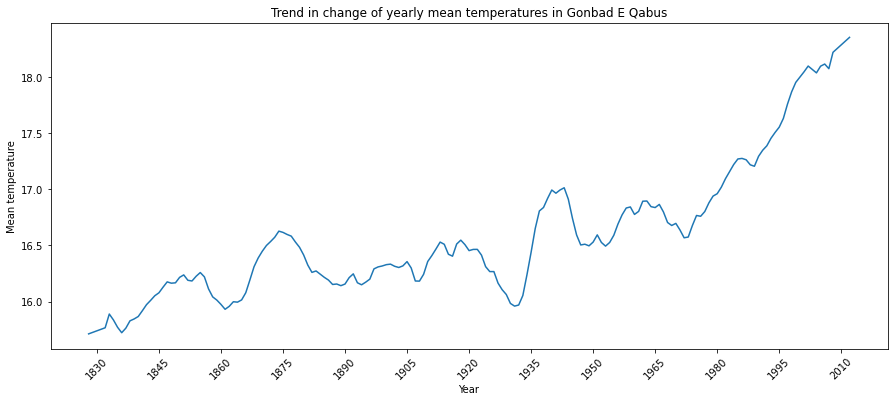

In [219]:
# plotting trends for each city

# iterating over cities
for key in cities_dict.keys():
    # creating yearly means
    data_city = cities_dict[key]
    yearly = data_city.groupby("year").mean()
    # decomposing timeseries
    result = seasonal_decompose(yearly.AverageTemperature, model='additive',period=10, extrapolate_trend='freq')    
    
    # plotting results
    plt.figure(figsize=(15,6))
    plt.plot(yearly.index, result.trend)
    plt.xlabel("Year")
    plt.ylabel("Mean temperature")
    # limiting number of x ticks showing
    plt.axes().xaxis.set_major_locator(plt.MaxNLocator(20))
    plt.xticks(rotation=45)
    plt.title(f"Trend in change of yearly mean temperatures in {key}")

plt.show()

## ARIMA prediction of further temperature rise

In [54]:
# filtering out warnings
import warnings
warnings.filterwarnings("ignore")
# creating list of arima orders to test and a dictionary to save best one for each city
orders = [(x,y,z) for x in range(4) for y in range(3) for z in range(3)]
best_orders = {}

# iterating over cities
for key in cities_dict.keys():
    # creating timeseries for prediction
    series = cities_dict[key].groupby("year").mean()["AverageTemperature"]
    #progress tracking
    print(key)
    # creating variables to save best order, it's score and a string to check if any prediction was better than naive
    best_order = ()
    best_score = float("inf")
    is_naive = ""
    # creating splits object
    X = series
    splits = TimeSeriesSplit(n_splits=4)
    
    # iterating over orders
    for order in orders:
        # not all models can be created with given parameters
        try:
            print(order)
            # creating variables to save errors for each split
            errors = []
            naive_errors = []
            # iterating over splits
            for train_index,test_index in splits.split(X):
                # creating train and test variables
                train = X[train_index]
                test = X[test_index]
                
                # creating variables for one forward testing
                history = [x for x in train]
                predicted = []
                naive = X[test_index-1]
                
                # one forward arima testing
                for t in test:
                    # creating and fitting model
                    model = ARIMA(history,order)
                    model_fit = model.fit()
                    # forecasting and appending variables
                    val = model_fit.forecast()[0]
                    predicted.append(val)
                    history.append(t)
                
                # calculating and appending errors for current split
                error = metrics.mean_squared_error(test,predicted)
                naive_err = metrics.mean_squared_error(test,naive)
                errors.append(error)
                naive_errors.append(naive_err)
            
            # calculating mean prediction error for tested order
            error_order = np.mean(errors)
            naive_error = np.mean(naive_errors)
            
            # checking if error is smaller than threshold (naive prediction error)
            if error_order < naive_error:
                is_naive = "No"
                # checking if error is smaller than current best model error
                if error_order < best_score:
                    # updating variables
                    best_order = order
                    best_score = error_order
        # passing orders which couldn't be constructed
        except:
            continue
    
    # saving best parameters to dict if any of models was better than naive prediction
    if is_naive != "No":
        best_orders[key] = "No prediction was better than naive"
    elif is_naive == "No":
        best_orders[key] = best_order
    

Trondheim
(0, 0, 0)
(0, 0, 1)
(0, 0, 2)
(0, 1, 0)
(0, 1, 1)
(0, 1, 2)
(0, 2, 0)
(0, 2, 1)
(0, 2, 2)
(1, 0, 0)
(1, 0, 1)
(1, 0, 2)
(1, 1, 0)
(1, 1, 1)
(1, 1, 2)
(1, 2, 0)
(1, 2, 1)
(1, 2, 2)
(2, 0, 0)
(2, 0, 1)
(2, 0, 2)
(2, 1, 0)
(2, 1, 1)
(2, 1, 2)
(2, 2, 0)
(2, 2, 1)
(2, 2, 2)
(3, 0, 0)
(3, 0, 1)
(3, 0, 2)
(3, 1, 0)
(3, 1, 1)
(3, 1, 2)
(3, 2, 0)
(3, 2, 1)
(3, 2, 2)
Cork
(0, 0, 0)
(0, 0, 1)
(0, 0, 2)
(0, 1, 0)
(0, 1, 1)
(0, 1, 2)
(0, 2, 0)
(0, 2, 1)
(0, 2, 2)
(1, 0, 0)
(1, 0, 1)
(1, 0, 2)
(1, 1, 0)
(1, 1, 1)
(1, 1, 2)
(1, 2, 0)
(1, 2, 1)
(1, 2, 2)
(2, 0, 0)
(2, 0, 1)
(2, 0, 2)
(2, 1, 0)
(2, 1, 1)
(2, 1, 2)
(2, 2, 0)
(2, 2, 1)
(2, 2, 2)
(3, 0, 0)
(3, 0, 1)
(3, 0, 2)
(3, 1, 0)
(3, 1, 1)
(3, 1, 2)
(3, 2, 0)
(3, 2, 1)
(3, 2, 2)
Messina
(0, 0, 0)
(0, 0, 1)
(0, 0, 2)
(0, 1, 0)
(0, 1, 1)
(0, 1, 2)
(0, 2, 0)
(0, 2, 1)
(0, 2, 2)
(1, 0, 0)
(1, 0, 1)
(1, 0, 2)
(1, 1, 0)
(1, 1, 1)
(1, 1, 2)
(1, 2, 0)
(1, 2, 1)
(1, 2, 2)
(2, 0, 0)
(2, 0, 1)
(2, 0, 2)
(2, 1, 0)
(2, 1, 1)
(2, 1, 2)
(2, 2, 0)
(2, 2, 

In [55]:
best_orders

{'Trondheim': (2, 1, 1),
 'Cork': (0, 1, 1),
 'Messina': (0, 1, 1),
 'Tuxtla Gutiérrez': (1, 1, 2),
 'Huancayo': (2, 1, 1),
 'Jimma': (3, 1, 0),
 'Ilesha': (0, 1, 1),
 'Seoul': (0, 1, 2),
 'Bangalore': (1, 1, 1),
 'Christchurch': (0, 1, 2),
 'Irbid': (0, 1, 1),
 'Gonbad E Qabus': (0, 1, 1)}

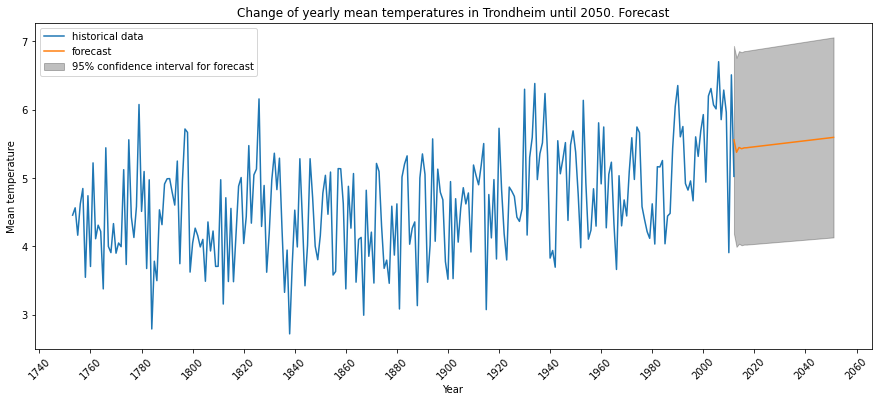

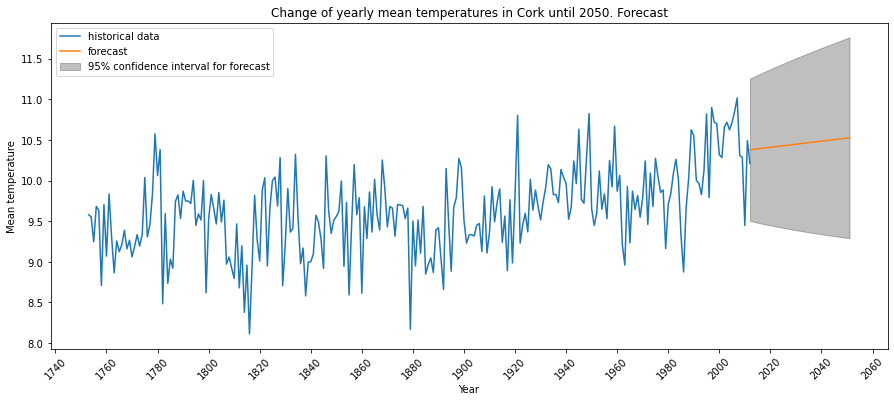

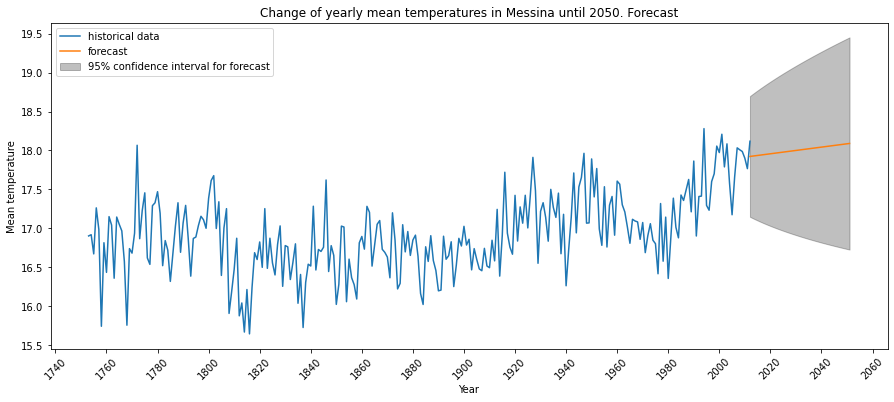

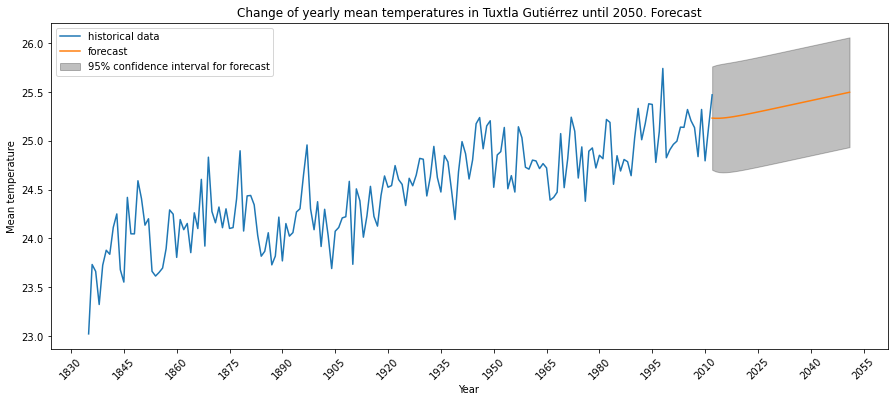

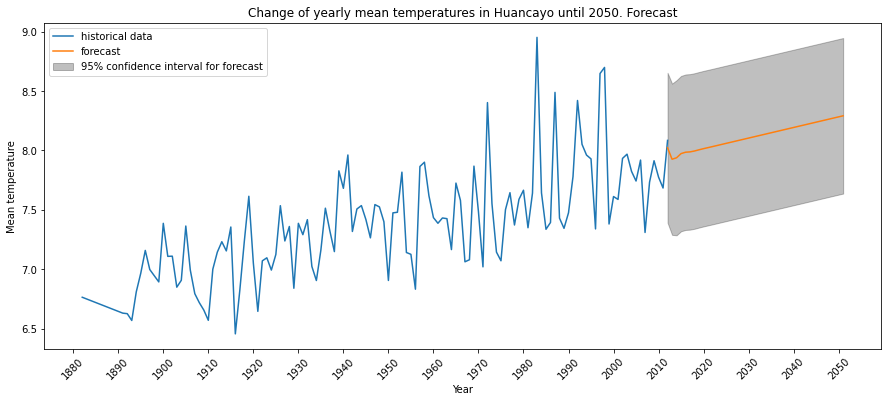

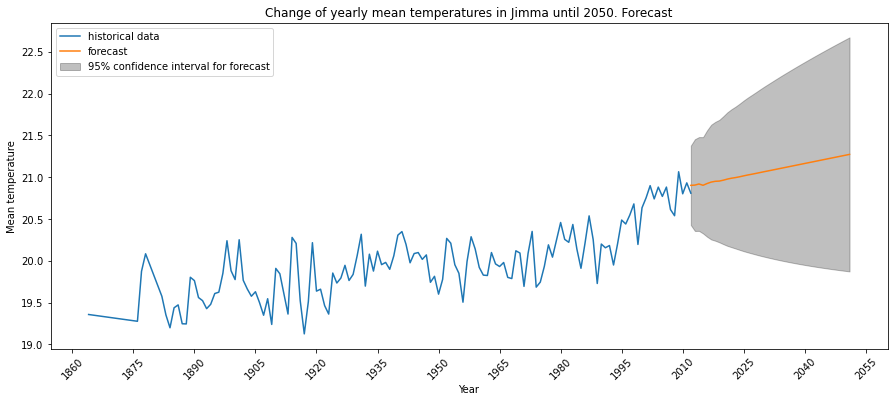

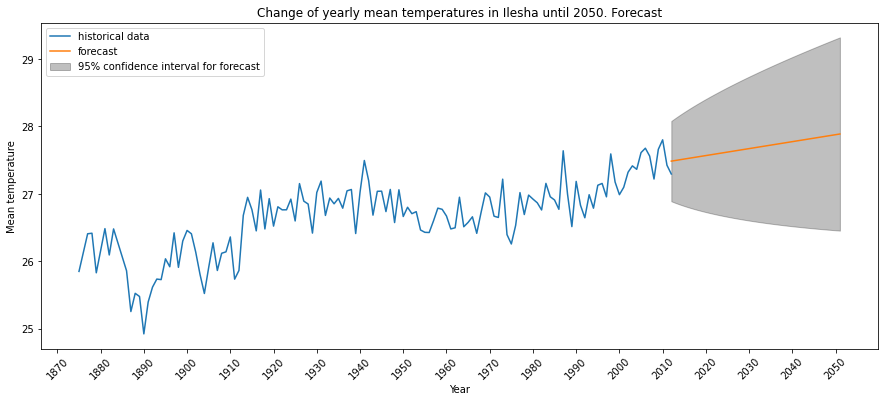

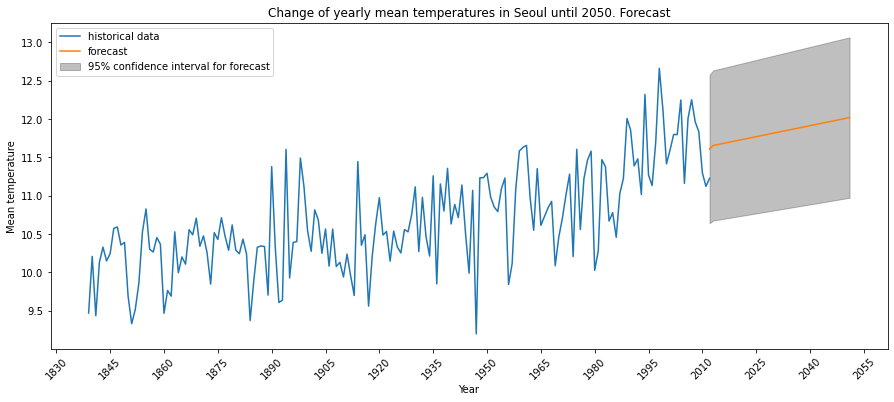

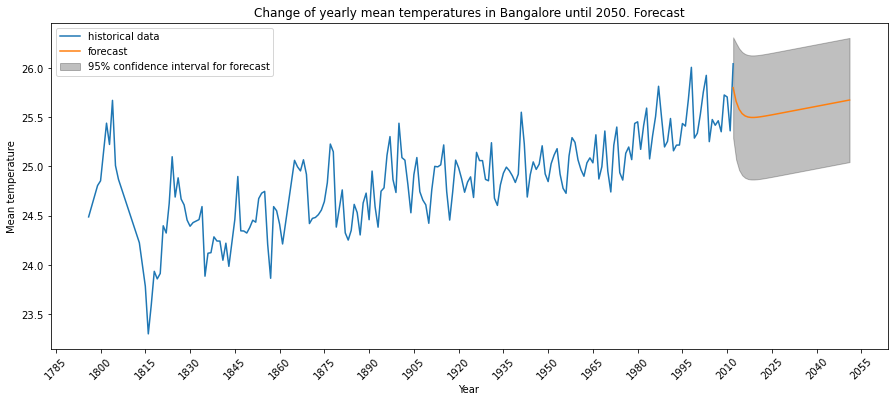

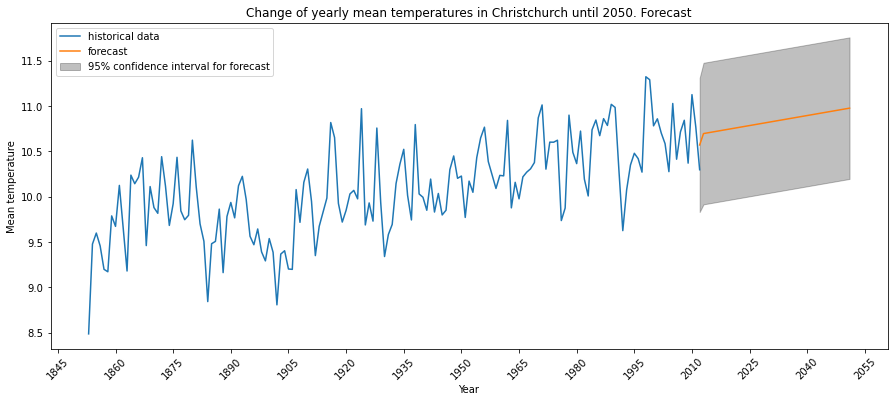

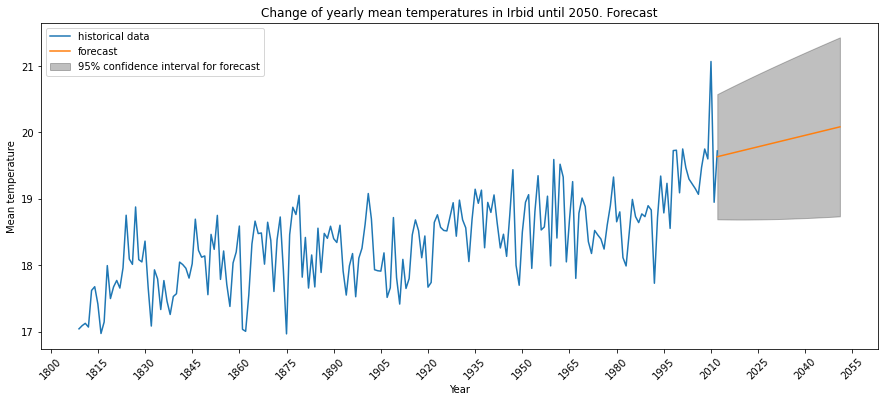

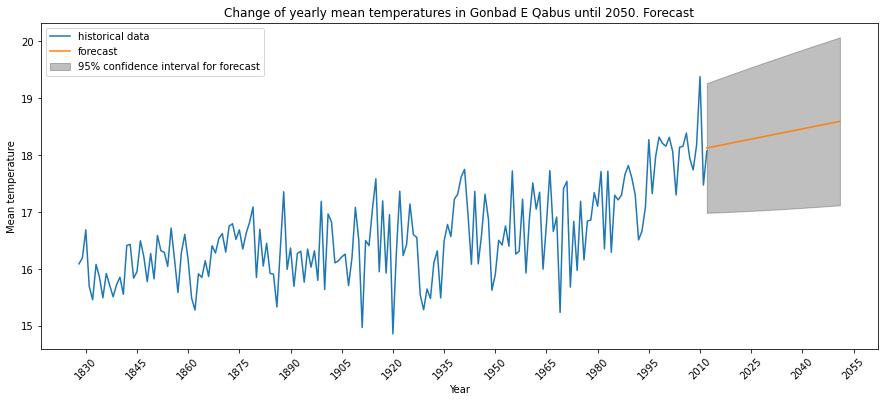

In [209]:
# using best model for forecasting mean temperatures in 2050

#iterating over city - model pairs
for key, value in best_orders.items():
    # creating variables
    X = cities_dict[key].groupby("year").mean()["AverageTemperature"]
    order = best_orders[key]
    # fitting model
    model = ARIMA(X,order)
    model_fit = model.fit()
    fc,de, confint = model_fit.forecast(40)
    fc_idx = np.arange(X.index[-1],X.index[-1]+40)
    fc_series = pd.Series(fc,index=fc_idx)
    lower_series = pd.Series(confint[:, 0], fc_idx)
    upper_series = pd.Series(confint[:, 1], fc_idx)

    
    # plotting forecast
    # creating timeseries for plotting
    # plotting
    plt.show()
    plt.figure(figsize=(15,6))
    plt.plot(X,label = "historical data")
    plt.plot(fc_series,label = "forecast")
    plt.fill_between(lower_series.index,
                lower_series,
                upper_series, color='k', alpha=.25, label = "95% confidence interval for forecast")
    plt.xlabel("Year")
    plt.ylabel("Mean temperature")
    # limiting number of ticks showing on x axis
    plt.axes().xaxis.set_major_locator(plt.MaxNLocator(20))
    plt.xticks(rotation=45)
    plt.legend(loc="upper left")
    plt.title(f"Change of yearly mean temperatures in {key} until 2050. Forecast")
    plt.show()
    

## ARIMA prediction of further trend in mean temperatures

In [203]:
# filtering out warnings
import warnings
warnings.filterwarnings("ignore")
# creating list of arima orders to test and a dictionary to save best one for each city
orders = [(x,y,z) for x in range(4) for y in range(3) for z in range(3)]
best_trend_fc = {}

# iterating over cities
for key in cities_dict.keys():
    # creating timeseries of trends for prediction
    series = cities_dict[key].groupby("year").mean().reset_index()["AverageTemperature"]
    result = seasonal_decompose(series, model='additive',period=10, extrapolate_trend='freq')
    trend = pd.Series(result.trend,index = series.index)
    #progress tracking
    print(key)
    # creating variables to save best order, it's score and a string to check if any prediction was better than naive
    best_order = ()
    best_score = float("inf")
    is_naive = ""
    # creating splits object
    X = trend
    splits = TimeSeriesSplit(n_splits=4)
    
    # iterating over orders
    for order in orders:
        # not all models can be created with given parameters
        try:
            print(order)
            # creating variables to save errors for each split
            errors = []
            naive_errors = []
            # iterating over splits
            for train_index,test_index in splits.split(X):
                # creating train and test variables
                train = X[train_index]
                test = X[test_index]
                
                # creating variables for one forward testing
                history = [x for x in train]
                predicted = []
                naive = X[test_index-1]
                
                # one forward arima testing
                for t in test:
                    # creating and fitting model
                    model = ARIMA(history,order)
                    model_fit = model.fit()
                    # forecasting and appending variables
                    val = model_fit.forecast()[0]
                    predicted.append(val)
                    history.append(t)
                
                # calculating and appending errors for current split
                error = metrics.mean_squared_error(test,predicted)
                naive_err = metrics.mean_squared_error(test,naive)
                errors.append(error)
                naive_errors.append(naive_err)
            
            # calculating mean prediction error for tested order
            error_order = np.mean(errors)
            naive_error = np.mean(naive_errors)
            
            # checking if error is smaller than threshold (naive prediction error)
            if error_order < naive_error:
                is_naive = "No"
                # checking if error is smaller than current best model error
                if error_order < best_score:
                    # updating variables
                    best_order = order
                    best_score = error_order
        # passing orders which couldn't be constructed
        except:
            continue
    
    # saving best parameters to dict if any of models was better than naive prediction
    if is_naive != "No":
        best_trend_fc[key] = "No prediction was better than naive"
    elif is_naive == "No":
        best_trend_fc[key] = best_order

Trondheim
(0, 0, 0)
(0, 0, 1)
(0, 0, 2)
(0, 1, 0)
(0, 1, 1)
(0, 1, 2)
(0, 2, 0)
(0, 2, 1)
(0, 2, 2)
(1, 0, 0)
(1, 0, 1)
(1, 0, 2)
(1, 1, 0)
(1, 1, 1)
(1, 1, 2)
(1, 2, 0)
(1, 2, 1)
(1, 2, 2)
(2, 0, 0)
(2, 0, 1)
(2, 0, 2)
(2, 1, 0)
(2, 1, 1)
(2, 1, 2)
(2, 2, 0)
(2, 2, 1)
(2, 2, 2)
(3, 0, 0)
(3, 0, 1)
(3, 0, 2)
(3, 1, 0)
(3, 1, 1)
(3, 1, 2)
(3, 2, 0)
(3, 2, 1)
(3, 2, 2)
Cork
(0, 0, 0)
(0, 0, 1)
(0, 0, 2)
(0, 1, 0)
(0, 1, 1)
(0, 1, 2)
(0, 2, 0)
(0, 2, 1)
(0, 2, 2)
(1, 0, 0)
(1, 0, 1)
(1, 0, 2)
(1, 1, 0)
(1, 1, 1)
(1, 1, 2)
(1, 2, 0)
(1, 2, 1)
(1, 2, 2)
(2, 0, 0)
(2, 0, 1)
(2, 0, 2)
(2, 1, 0)
(2, 1, 1)
(2, 1, 2)
(2, 2, 0)
(2, 2, 1)
(2, 2, 2)
(3, 0, 0)
(3, 0, 1)
(3, 0, 2)
(3, 1, 0)
(3, 1, 1)
(3, 1, 2)
(3, 2, 0)
(3, 2, 1)
(3, 2, 2)
Messina
(0, 0, 0)
(0, 0, 1)
(0, 0, 2)
(0, 1, 0)
(0, 1, 1)
(0, 1, 2)
(0, 2, 0)
(0, 2, 1)
(0, 2, 2)
(1, 0, 0)
(1, 0, 1)
(1, 0, 2)
(1, 1, 0)
(1, 1, 1)
(1, 1, 2)
(1, 2, 0)
(1, 2, 1)
(1, 2, 2)
(2, 0, 0)
(2, 0, 1)
(2, 0, 2)
(2, 1, 0)
(2, 1, 1)
(2, 1, 2)
(2, 2, 0)
(2, 2, 

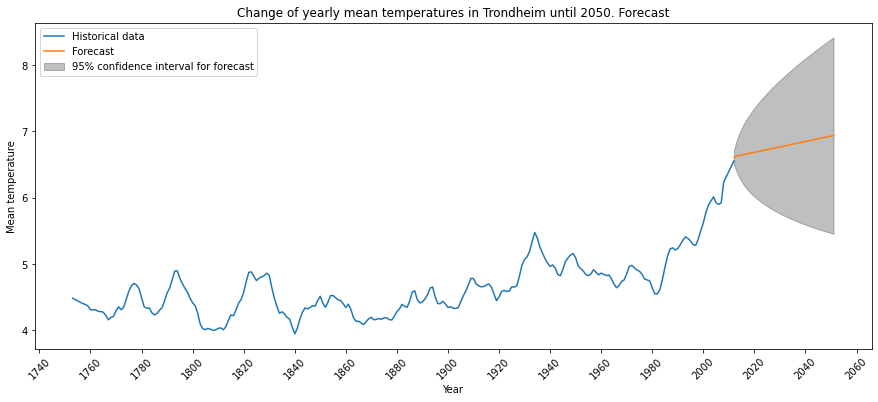

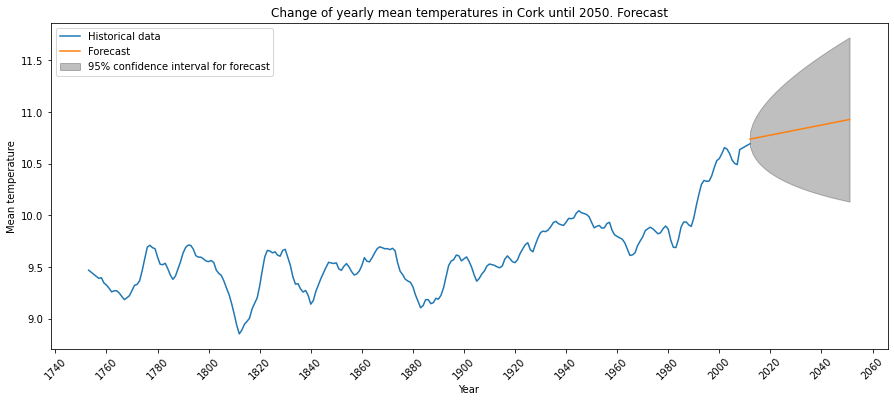

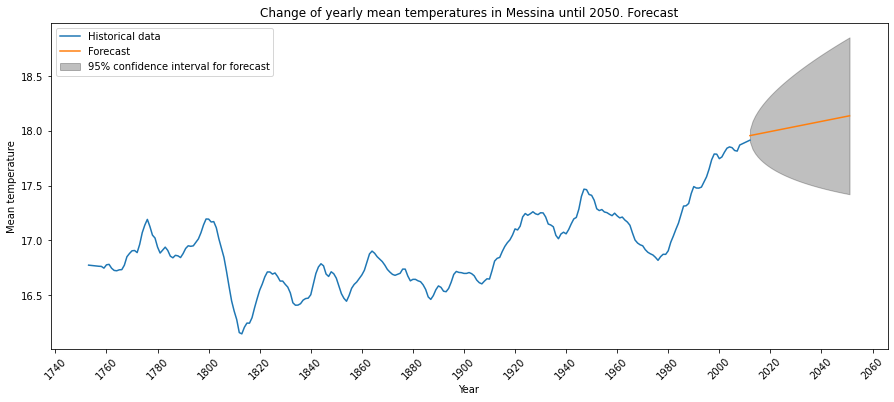

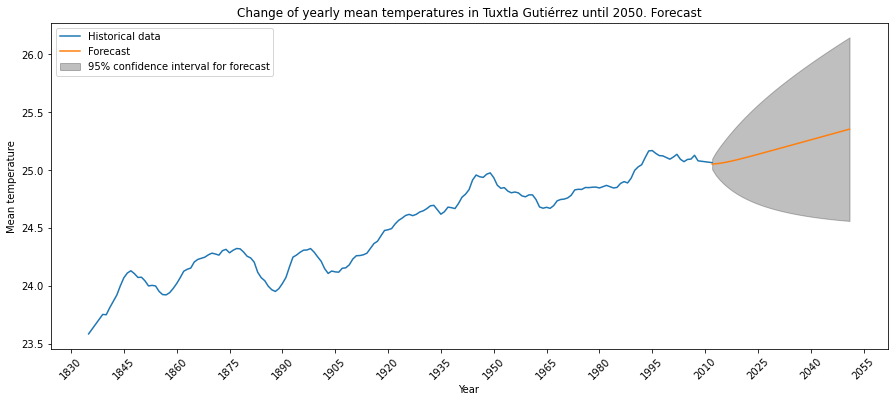

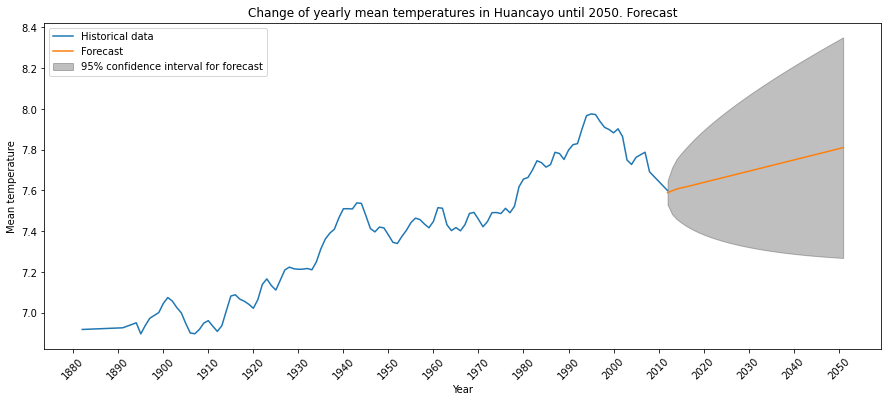

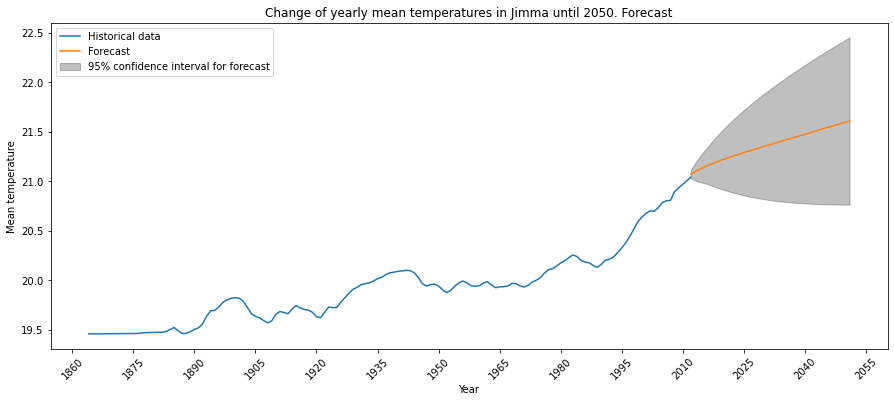

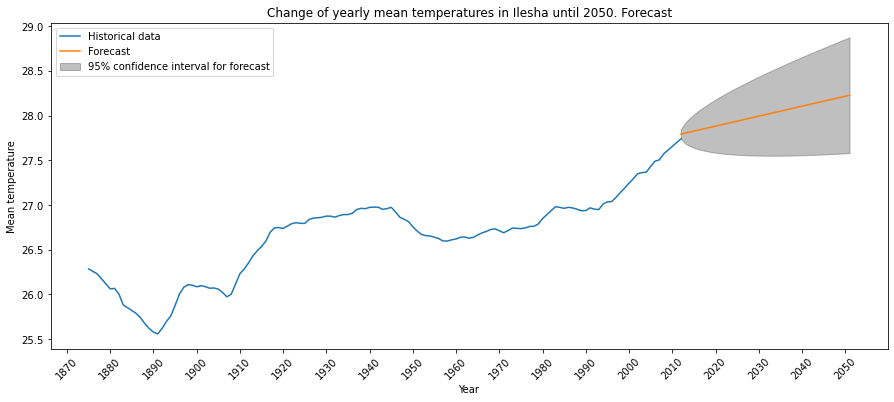

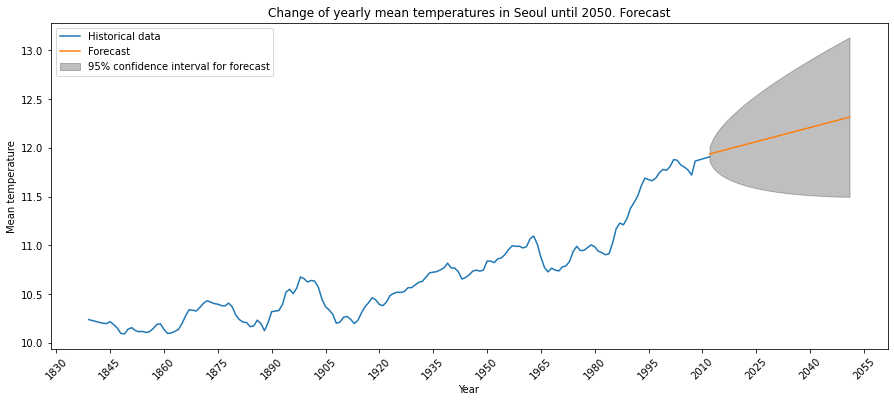

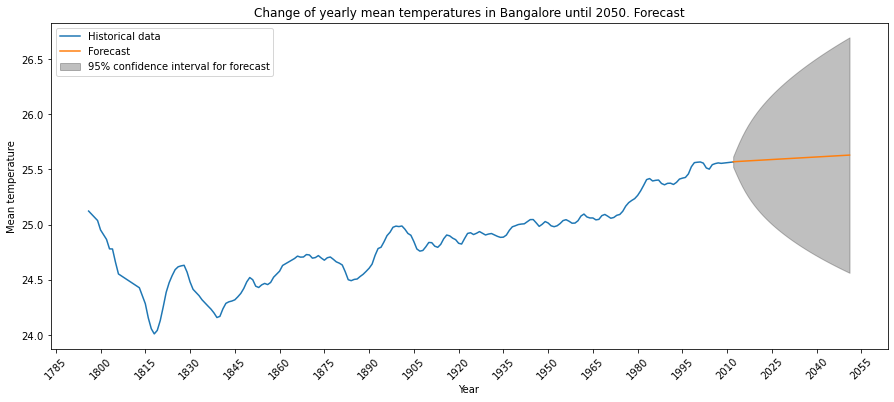

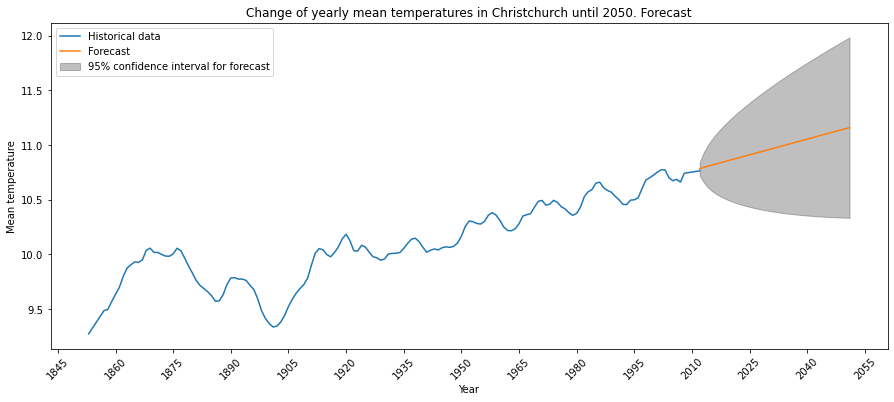

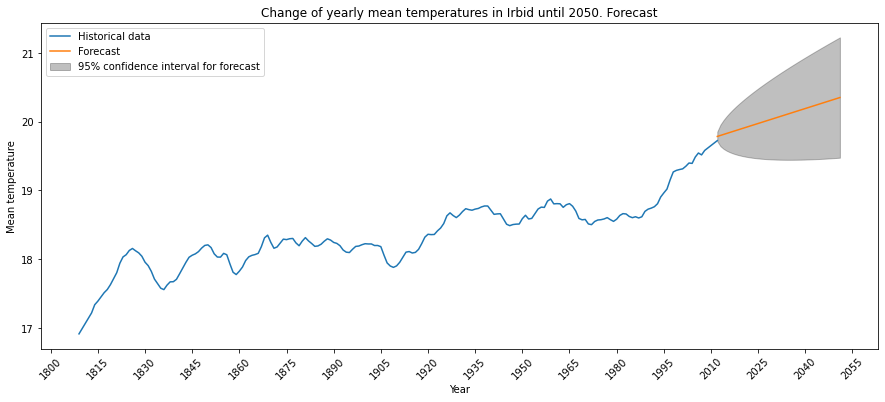

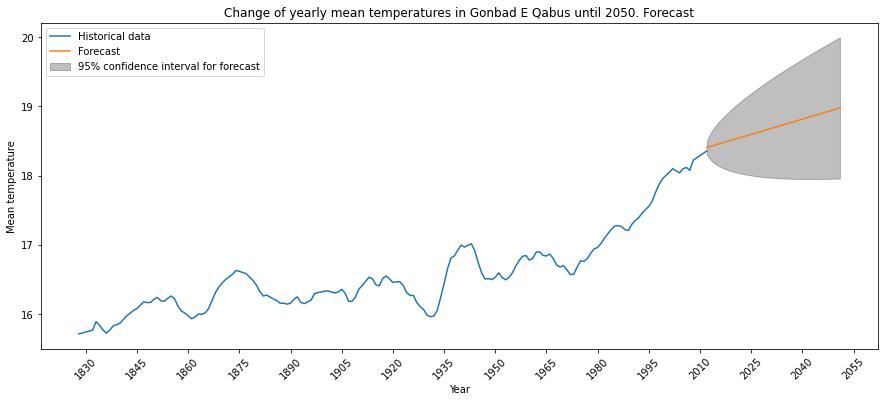

In [210]:
#iterating over city - model pairs
for key, value in best_trend_fc.items():
    # creating variables
    # timeseries
    series = cities_dict[key].groupby("year").mean()["AverageTemperature"]
    # trend from timeseries
    X = seasonal_decompose(series, model='additive',period=10, extrapolate_trend='freq').trend
    order = best_orders[key]
    # fitting model
    model = ARIMA(X,order)
    model_fit = model.fit()
    fc,de, confint = model_fit.forecast(40)
    fc_idx = np.arange(X.index[-1],X.index[-1]+40)
    fc_series = pd.Series(fc,index=fc_idx)
    lower_series = pd.Series(confint[:, 0], fc_idx)
    upper_series = pd.Series(confint[:, 1], fc_idx)

    
    # plotting forecast
    # creating timeseries for plotting
    # plotting
    plt.show()
    plt.figure(figsize=(15,6))
    # plotting data and prediction
    plt.plot(X, label ="Historical data")
    plt.plot(fc_series,label = "Forecast" )
    # adding confidence interval
    plt.fill_between(lower_series.index,
                lower_series,
                upper_series, color='k', alpha=.25, label = "95% confidence interval for forecast")
    plt.xlabel("Year")
    plt.ylabel("Mean temperature")
    # limiting number of ticks showing on x axis
    plt.axes().xaxis.set_major_locator(plt.MaxNLocator(20))
    plt.xticks(rotation=45)
    plt.legend(loc = "upper left")
    plt.title(f"Change of yearly mean temperatures in {key} until 2050. Forecast")
    plt.show()

## Conclusions

These analysis indisputabli show that the global temperatures are rising, and are going to rise further still. These analyses show what will happen if we continue to do "buissness as usuall" and do not drastically reduce our emissions